# Car Classification Model

**Задача:** сделать проект по классификации автомашин в произвольном формате. Скрипт должен по предоставленной фотографии определять марку, модель и цвет автомобиля

## Определение марки и модели автомобиля

В качестве датасета для обучения воспользуемся [Cars Dataset](https://ai.stanford.edu/~jkrause/cars/car_dataset.html), содержащий 16 185 изображений 196 классов - марок+моделей автомобилей, например, BMW 1 Series Convertible 2012. Датасет разделен на обучение и тест (50 / 50).

In [2]:
import os
import argparse
import shutil
import random
import json
import numpy as np

import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

from sklearn.metrics import roc_auc_score
from scipy.io import loadmat
from pathlib import Path

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
torch.random.manual_seed(123)
np.random.seed(123)
random.seed(123)

In [ ]:
class StanfordCarsDataset(Dataset):

    def __init__(self, images, labels, transforms=None):
        self.images = images
        self.labels = labels
        self.transforms = transforms

    def __getitem__(self, index):
        img = cv2.imread(self.images[index])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = torch.tensor(np.transpose(img, [2,0,1]))
        if self.transforms:
            img = self.transforms(img.float().div(255))
        return (img, self.labels[index])

    def __len__(self):
        return len(self.images)

In [ ]:
class MultiClassTrainer:

    def __init__(self, model, optimizer, scheduler, num_classes,
                 path_to_save='./', suffix='model'):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.num_classes = num_classes
        self.criterion = nn.CrossEntropyLoss()
        self.path_to_save = path_to_save
        self.suffix = suffix
        self.metrics = {
            k: {'loss':[], 'acc':[], 'roc-auc':[]} for k in ['train','test']
        }
        self.best_roc_auc = None


    def roc_auc(self, epoch_target, epoch_predict):
        epoch_target = np.hstack(epoch_target)
        epoch_predict = np.hstack(epoch_predict)
        bin_predict = np.zeros(
            (epoch_predict.shape[0], self.num_classes), dtype=int)
        bin_target = np.zeros_like(bin_predict)
        bin_predict[np.arange(epoch_predict.shape[0]), epoch_predict] = 1
        bin_target[np.arange(epoch_target.shape[0]), epoch_target] = 1
        return roc_auc_score(bin_target, bin_predict, multi_class='ovr') 


    def train(self, loader):

        self.model.train()
        epoch_loss, epoch_acc = 0, 0
        epoch_predict, epoch_target = [], []
        for (batch, target) in loader:
            
            self.optimizer.zero_grad()
            outputs = self.model(batch.to(DEVICE))
            _, predicts = torch.max(outputs, 1)
            predicts = predicts.detach().cpu()

            loss = self.criterion(outputs, target.long().to(DEVICE))  
            epoch_loss += loss.item()
            epoch_acc += torch.sum(predicts == target).float().item()
            epoch_predict.append(predicts.numpy())
            epoch_target.append(target.long().numpy())

            loss.backward()
            self.optimizer.step()

        num_obj = np.hstack(epoch_target).shape[0]
        self.metrics['train']['loss'].append(epoch_loss / num_obj)
        self.metrics['train']['acc'].append(epoch_acc / num_obj)
        self.metrics['train']['roc-auc'].append(
            self.roc_auc(epoch_target, epoch_predict))
        

    def test(self, loader, multi_class='ovo', save_best=False):
        self.model.eval()
        epoch_loss, epoch_acc = 0, 0
        epoch_predict, epoch_target = [], []
        for (batch, target) in loader:
            
            outputs = self.model(batch.to(DEVICE))
            _, predicts = torch.max(outputs, 1)
            predicts = predicts.detach().cpu()

            loss = self.criterion(outputs, target.long().to(DEVICE))  
            epoch_loss += loss.item()
            epoch_acc += torch.sum(predicts == target).float().item()
            epoch_predict.append(predicts.numpy())
            epoch_target.append(target.long().numpy())

        num_obj = np.hstack(epoch_target).shape[0]
        self.metrics['test']['loss'].append(epoch_loss / num_obj)
        self.metrics['test']['acc'].append(epoch_acc / num_obj)
        self.metrics['test']['roc-auc'].append(
            self.roc_auc(epoch_target, epoch_predict))

        if save_best and self.best_roc_auc is not None and 
                self.metrics['test']['roc-auc'][-1] > self.best_roc_auc:
            self.save_model()
            self.best_roc_auc = self.metrics['test']['roc-auc'][-1]

        self.scheduler.step(self.metrics['test']['roc-auc'][-1])


    def save_model(self, best=False):
        prefix = 'best_' if best else ''
        torch.save(
            self.model.state_dict(),
            Path(self.path_to_save).joinpath(f'{prefix}{self.suffix}.pth')
        )
    
    def save_metrics(self):
        path = Path(self.path_to_save).joinpath(f'{self.suffix}_metrics.json')
        with open(path,'w') as f:
            json.dump(self.metrics, f)

In [ ]:
annotations = loadmat('cars_annos.mat')
class_names = annotations['class_names']
images, bboxes, labels, split = [], [], [], []
for img, x1, y1, x2, y2, label, s in annotations['annotations'].flatten():
    images.append(img)
    bboxes.append((x1, y1, x2, y2))
    labels.append(label)
    split.append(s == 0)
images = np.vstack(images).flatten()
bboxes = np.hstack(bboxes).transpose()[0]
labels = np.vstack(labels).flatten() - 1
split = np.vstack(split).flatten()

# ('bbox_x1', 'O'), ('bbox_y1', 'O'), ('bbox_x2', 'O'), ('bbox_y2', 'O'), ('class', 'O'), ('test', 'O')

In [ ]:
NUM_CLASSES = len(set(labels))
BATCH_SIZE = 64
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_CLASSES, DEVICE

(196, 'cuda')

In [ ]:
train_transforms = transforms.Compose(
    [
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
test_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

train_dataset = StanfordCarsDataset(
    images[split], labels[split], train_transforms)
test_dataset = StanfordCarsDataset(
    images[~split], labels[~split], test_transforms)
                 
train_iter = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_iter = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

## Mark-Model Classification: Resnet34 vs VGG16

Для построения классификатора возьмем модели Resnet34 и VGG16, предобученные на датасете ImageNet. Веса будут хорошей инициализацией. Заменим последний полносвязный слой на слой с 196 выходами и обучим всю сеть полностью на новом таргете.

### Resnet34

In [ ]:
model_rsn = models.resnet34(pretrained=True) # vgg19, resnext101_32x8d
input_dim = model_rsn.fc.in_features
model_rsn.fc = nn.Linear(
    in_features=input_dim, out_features=NUM_CLASSES, bias=True)

model_rsn = model_rsn.to(DEVICE)
optimizer_rsn = optim.SGD(model_rsn.parameters(), lr=0.01, momentum=0.9)
scheduler_rsn = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_rsn, mode='max', patience=2, threshold=0.001, eps=1e-5)

trainer_rsn = MultiClassTrainer(
    model_rsn, optimizer_rsn, scheduler_rsn, NUM_CLASSES, suffix='resnet34')

for epoch in range(10):
    print(f'\n{epoch+1:02d}')
    trainer_rsn.train(train_iter)
    trainer_rsn.test(test_iter)
    for t in ['train','test']:
      print(
          '{:>5}: Loss={:.4f}, Acc={:.4f}, ROC-AUC={:.4f}'.format(
              t, trainer_rsn.metrics[t]['loss'][-1], 
              trainer_rsn.metrics[t]['acc'][-1],
              trainer_rsn.metrics[t]['roc-auc'][-1])
      )

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth




01
train: Loss=0.0719, Acc=0.0748, ROC-AUC=0.5340
 test: Loss=0.0520, Acc=0.2083, ROC-AUC=0.6001

02
train: Loss=0.0454, Acc=0.3092, ROC-AUC=0.6515
 test: Loss=0.0348, Acc=0.4228, ROC-AUC=0.7069

03
train: Loss=0.0326, Acc=0.4758, ROC-AUC=0.7357
 test: Loss=0.0256, Acc=0.5530, ROC-AUC=0.7767

04
train: Loss=0.0261, Acc=0.5760, ROC-AUC=0.7860
 test: Loss=0.0220, Acc=0.5986, ROC-AUC=0.7986

05
train: Loss=0.0219, Acc=0.6349, ROC-AUC=0.8154
 test: Loss=0.0185, Acc=0.6643, ROC-AUC=0.8324

06
train: Loss=0.0199, Acc=0.6611, ROC-AUC=0.8286
 test: Loss=0.0166, Acc=0.6903, ROC-AUC=0.8430

07
train: Loss=0.0174, Acc=0.7044, ROC-AUC=0.8512
 test: Loss=0.0166, Acc=0.6977, ROC-AUC=0.8468

08
train: Loss=0.0161, Acc=0.7297, ROC-AUC=0.8636
 test: Loss=0.0150, Acc=0.7255, ROC-AUC=0.8633

09
train: Loss=0.0153, Acc=0.7377, ROC-AUC=0.8677
 test: Loss=0.0151, Acc=0.7227, ROC-AUC=0.8592

10
train: Loss=0.0136, Acc=0.7710, ROC-AUC=0.8850
 test: Loss=0.0153, Acc=0.7207, ROC-AUC=0.8593


In [ ]:
trainer_rsn.save_model()
trainer_rsn.save_metrics()

### VGG 13

In [ ]:
torch.random.manual_seed(123)
np.random.seed(123)
random.seed(123)

In [ ]:
model_vgg = models.vgg13(pretrained=True) 
input_dim = model_vgg.classifier[6].in_features
model_vgg.classifier[6] = nn.Linear(
    in_features=input_dim, out_features=NUM_CLASSES, bias=True)

model_vgg = model_vgg.to(DEVICE)
optimizer_vgg = optim.SGD(model_vgg.parameters(), lr=0.01, momentum=0.9)
scheduler_vgg = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_vgg, mode='max', patience=3, threshold=0.001, eps=1e-5)

trainer_vgg = MultiClassTrainer(
    model_vgg, optimizer_vgg, scheduler_vgg, NUM_CLASSES, suffix='vgg13')

for epoch in range(10):
    print(f'\n{epoch+1:02d}')
    trainer_vgg.train(train_iter)
    trainer_vgg.test(test_iter)
    for t in ['train','test']:
      print(
          '{:>5}: Loss={:.4f}, Acc={:.4f}, ROC-AUC={:.4f}'.format(
              t, trainer_vgg.metrics[t]['loss'][-1], 
              trainer_vgg.metrics[t]['acc'][-1],
              trainer_vgg.metrics[t]['roc-auc'][-1])
      )

Downloading: "https://download.pytorch.org/models/vgg13-c768596a.pth" to /root/.cache/torch/hub/checkpoints/vgg13-c768596a.pth




01
train: Loss=0.0794, Acc=0.0239, ROC-AUC=0.5086
 test: Loss=0.0690, Acc=0.0971, ROC-AUC=0.5443

02
train: Loss=0.0670, Acc=0.0974, ROC-AUC=0.5457
 test: Loss=0.0539, Acc=0.1847, ROC-AUC=0.5887

03
train: Loss=0.0569, Acc=0.1690, ROC-AUC=0.5816
 test: Loss=0.0438, Acc=0.3057, ROC-AUC=0.6497

04
train: Loss=0.0493, Acc=0.2437, ROC-AUC=0.6190
 test: Loss=0.0351, Acc=0.4151, ROC-AUC=0.7059

05
train: Loss=0.0439, Acc=0.3172, ROC-AUC=0.6559
 test: Loss=0.0334, Acc=0.4345, ROC-AUC=0.7169

06
train: Loss=0.0407, Acc=0.3560, ROC-AUC=0.6751
 test: Loss=0.0294, Acc=0.4955, ROC-AUC=0.7464

07
train: Loss=0.0372, Acc=0.4104, ROC-AUC=0.7034
 test: Loss=0.0255, Acc=0.5614, ROC-AUC=0.7782

08
train: Loss=0.0337, Acc=0.4559, ROC-AUC=0.7259
 test: Loss=0.0235, Acc=0.6010, ROC-AUC=0.7999

09
train: Loss=0.0315, Acc=0.4903, ROC-AUC=0.7436
 test: Loss=0.0209, Acc=0.6298, ROC-AUC=0.8133

10
train: Loss=0.0298, Acc=0.5123, ROC-AUC=0.7549
 test: Loss=0.0202, Acc=0.6444, ROC-AUC=0.8197


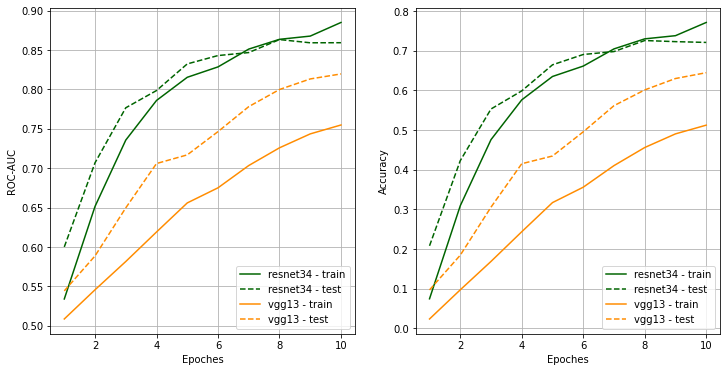

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
n_epoches = len(trainer_vgg.metrics['test']['roc-auc'])

axs[0].plot(
    np.arange(n_epoches)+1, trainer_rsn.metrics['train']['roc-auc'],
    color='darkgreen', label='resnet34 - train')
axs[0].plot(
    np.arange(n_epoches)+1, trainer_rsn.metrics['test']['roc-auc'],
    color='darkgreen', ls='--', label='resnet34 - test')
axs[0].plot(
    np.arange(n_epoches)+1, trainer_vgg.metrics['train']['roc-auc'],
    color='darkorange', label='vgg13 - train')
axs[0].plot(
    np.arange(n_epoches)+1, trainer_vgg.metrics['test']['roc-auc'],
    color='darkorange', ls='--', label='vgg13 - test')
axs[0].legend(loc='lower right')
axs[0].set_xlabel('Epoches')
axs[0].set_ylabel('ROC-AUC')
axs[0].grid()

axs[1].plot(
    np.arange(n_epoches)+1, trainer_rsn.metrics['train']['acc'],
    color='darkgreen', label='resnet34 - train')
axs[1].plot(
    np.arange(n_epoches)+1, trainer_rsn.metrics['test']['acc'],
    color='darkgreen', ls='--', label='resnet34 - test')
axs[1].plot(
    np.arange(n_epoches)+1, trainer_vgg.metrics['train']['acc'],
    color='darkorange', label='vgg13 - train')
axs[1].plot(
    np.arange(n_epoches)+1, trainer_vgg.metrics['test']['acc'],
    color='darkorange', ls='--', label='vgg13 - test')
axs[1].legend(loc='lower right')
axs[1].set_xlabel('Epoches')
axs[1].set_ylabel('Accuracy')
axs[1].grid();

In [ ]:
Path('./model/').mkdir()
idx_to_class = {i:c[0] for i,c in enumerate(class_names[0])}
with open('./model/idx_to_class.json','w') as f:
    json.dump(idx_to_class, f)

В качестве итогового варианта выбрана модель на основе сети Resnet34, посколько она достигает более высокое качества (по метрике ROC-AUC) за то же количество эпох, чем VGG16. Проведем для нее более длительную тренировку. 

In [ ]:
torch.random.manual_seed(123)
np.random.seed(123)
random.seed(123)

In [ ]:
model_final = models.resnet34(pretrained=True) # vgg19, resnext101_32x8d
input_dim = model_final.fc.in_features
model_final.fc = nn.Linear(
    in_features=input_dim, out_features=NUM_CLASSES, bias=True)

model_final = model_final.to(DEVICE)
optimizer_final = optim.SGD(model_final.parameters(), lr=0.01, momentum=0.9)
scheduler_final = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_final, mode='max', patience=2, threshold=0.001, eps=1e-5)

trainer_final = MultiClassTrainer(
    model_final, optimizer_final, scheduler_final, NUM_CLASSES,
    path_to_save='./model/', suffix='model_classifier')

for epoch in range(30):
    print(f'\n{epoch+1:02d}')
    trainer_final.train(train_iter)
    trainer_final.test(test_iter, save_best=True)
    for t in ['train','test']:
        print(
            '{:>5}: Loss={:.4f}, Acc={:.4f}, ROC-AUC={:.4f}'.format(
                t, trainer_final.metrics[t]['loss'][-1], 
                trainer_final.metrics[t]['acc'][-1],
                trainer_final.metrics[t]['roc-auc'][-1])
        )
    train_test_delta = trainer_final.metrics['train']['roc-auc'][-1] - \
      trainer_final.metrics['test']['roc-auc'][-1]
    if train_test_delta > 5:
        break
trainer_final.save_metrics()
trainer_final.save_model()


01
train: Loss=0.0719, Acc=0.0772, ROC-AUC=0.5352
 test: Loss=0.0527, Acc=0.2007, ROC-AUC=0.5965

02
train: Loss=0.0453, Acc=0.3078, ROC-AUC=0.6505
 test: Loss=0.0372, Acc=0.3837, ROC-AUC=0.6865

03
train: Loss=0.0325, Acc=0.4762, ROC-AUC=0.7359
 test: Loss=0.0252, Acc=0.5542, ROC-AUC=0.7762

04
train: Loss=0.0263, Acc=0.5670, ROC-AUC=0.7817
 test: Loss=0.0218, Acc=0.6139, ROC-AUC=0.8069

05
train: Loss=0.0219, Acc=0.6332, ROC-AUC=0.8148
 test: Loss=0.0221, Acc=0.6015, ROC-AUC=0.7992

06
train: Loss=0.0200, Acc=0.6645, ROC-AUC=0.8305
 test: Loss=0.0196, Acc=0.6444, ROC-AUC=0.8196

07
train: Loss=0.0174, Acc=0.7060, ROC-AUC=0.8516
 test: Loss=0.0163, Acc=0.6998, ROC-AUC=0.8483

08
train: Loss=0.0163, Acc=0.7237, ROC-AUC=0.8605
 test: Loss=0.0142, Acc=0.7378, ROC-AUC=0.8690

09
train: Loss=0.0152, Acc=0.7439, ROC-AUC=0.8709
 test: Loss=0.0136, Acc=0.7525, ROC-AUC=0.8744

10
train: Loss=0.0135, Acc=0.7749, ROC-AUC=0.8867
 test: Loss=0.0153, Acc=0.7212, ROC-AUC=0.8591

11
train: Loss=0.01

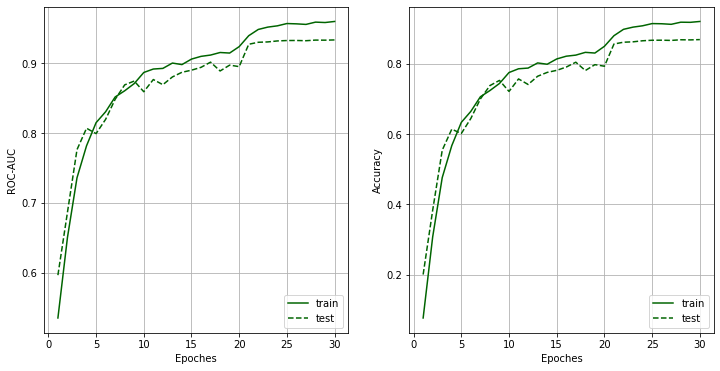

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
n_epoches = len(trainer_final.metrics['test']['roc-auc'])

axs[0].plot(
    np.arange(n_epoches)+1, trainer_final.metrics['train']['roc-auc'],
    color='darkgreen', label='train')
axs[0].plot(
    np.arange(n_epoches)+1, trainer_final.metrics['test']['roc-auc'],
    color='darkgreen', ls='--', label='test')
axs[0].legend(loc='lower right')
axs[0].set_xlabel('Epoches')
axs[0].set_ylabel('ROC-AUC')
axs[0].grid()

axs[1].plot(
    np.arange(n_epoches)+1, trainer_final.metrics['train']['acc'],
    color='darkgreen', label='train')
axs[1].plot(
    np.arange(n_epoches)+1, trainer_final.metrics['test']['acc'],
    color='darkgreen', ls='--', label='test')
axs[1].legend(loc='lower right')
axs[1].set_xlabel('Epoches')
axs[1].set_ylabel('Accuracy')
axs[1].grid();

## Color Classification

Для определения цвета автомобиля попробуем построить отдельный классификатор, обучив его на датасете [Vehicle Color Dataset](http://cloud.eic.hust.edu.cn:8071/~pchen/project.html).  

Датасет номинально состоит из 15 601 изображений автомобилей 8 цветов. Разбиваем их на обучение и тест (70 / 30) и решаем задачу многоклассовой классификации с помощью модели ResNet34.

In [ ]:
random.seed(345)

Path('./train/').mkdir()
Path('./test/').mkdir()

for c in Path('color').iterdir():
    if not c.is_dir():
        continue
    Path('./train/').joinpath(c.name).mkdir()
    Path('./test/').joinpath(c.name).mkdir()
    for f in c.iterdir():
        if cv2.imread(str(f)) is None:
            continue
        if random.random() < 0.7:
            shutil.move(f, Path('./train').joinpath(c.name).joinpath(f.name))
        else:
            shutil.move(f, Path('./test').joinpath(c.name).joinpath(f.name))

In [ ]:
train_color_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
test_color_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

train_color_dataset = datasets.ImageFolder('./train/', train_color_transforms)
test_color_dataset = datasets.ImageFolder('./test/', test_color_transforms)

train_color_loader = DataLoader(
    train_color_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_color_loader = DataLoader(
    test_color_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

color_names = train_color_dataset.classes

In [ ]:
model_color = models.resnet34(pretrained=True)
input_dim = model_color.fc.in_features
model_color.fc = nn.Linear(
    in_features=input_dim, out_features=len(color_names), bias=True)

model_color = model_color.to(DEVICE)
optimizer_color = optim.SGD(model_color.parameters(), lr=0.01, momentum=0.9)
scheduler_color = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_color, mode='max', patience=3, threshold=0.001, eps=1e-5)

In [ ]:
trainer_color = MultiClassTrainer(
    model_color, optimizer_color, scheduler_color, len(color_names),
    suffix='color'
)
for epoch in range(5):
    print(f'\n{epoch+1:02d}')
    trainer_color.train(train_color_loader)
    trainer_color.test(test_color_loader)
    for t in ['train','test']:
      print(
          '{:>5}: Loss={:.4f}, Acc={:.4f}, ROC-AUC={:.4f}'.format(
              t, trainer_color.metrics[t]['loss'][-1], 
              trainer_color.metrics[t]['acc'][-1],
              trainer_color.metrics[t]['roc-auc'][-1])
      )


01
train: Loss=0.0082, Acc=0.8239, ROC-AUC=0.8735
 test: Loss=0.0045, Acc=0.9053, ROC-AUC=0.9484

02
train: Loss=0.0049, Acc=0.8946, ROC-AUC=0.9321
 test: Loss=0.0032, Acc=0.9261, ROC-AUC=0.9523

03
train: Loss=0.0041, Acc=0.9122, ROC-AUC=0.9432
 test: Loss=0.0027, Acc=0.9363, ROC-AUC=0.9618

04
train: Loss=0.0036, Acc=0.9191, ROC-AUC=0.9490
 test: Loss=0.0027, Acc=0.9409, ROC-AUC=0.9646

05
train: Loss=0.0033, Acc=0.9276, ROC-AUC=0.9538
 test: Loss=0.0026, Acc=0.9392, ROC-AUC=0.9660


ROC-AUC очень быстро достигает высоких значений. Однако данные в датасете 
достаточно специфичные - изображения представляют собой снимки с дорожных камер, поэтому в данных присутствует шум из-за освещения. Плюс все автомобили сняты с одинакового ракурса (в отличие Стэнфордского датасета). 

Из-за больших различий в домене между датасетами (освещение, качество, ракурс) попробуем обучить только голову поверх экстрактора признаков модели, обученной на Стэнфордском датасете.

In [ ]:
model_joint = models.resnet34(pretrained=False)
input_dim = model_joint.fc.in_features
model_joint.fc = nn.Linear(
    in_features=input_dim, out_features=NUM_CLASSES, bias=True)

saved_model = torch.load('./resnet34.pth')
model_joint.load_state_dict(saved_model)

for params in model_joint.parameters():
    params.requires_grad = False 
model_joint.fc = nn.Linear(
    in_features=input_dim, out_features=len(color_names), bias=True)

In [ ]:
model_joint = model_joint.to(DEVICE)
optimizer_joint = optim.SGD(model_joint.parameters(), lr=0.01, momentum=0.9)
scheduler_joint = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_joint, mode='max', patience=3, threshold=0.001, eps=1e-5)

trainer_joint = MultiClassTrainer(
    model_joint, optimizer_joint, scheduler_joint, len(color_names),
    suffix='joint'
)

for epoch in range(10):
    print(f'\n{epoch+1:02d}')
    trainer_joint.train(train_color_loader)
    trainer_joint.test(test_color_loader)
    for t in ['train','test']:
      print(
          '{:>5}: Loss={:.4f}, Acc={:.4f}, ROC-AUC={:.4f}'.format(
              t, trainer_joint.metrics[t]['loss'][-1], 
              trainer_joint.metrics[t]['acc'][-1],
              trainer_joint.metrics[t]['roc-auc'][-1])
      )


01
train: Loss=0.0151, Acc=0.6592, ROC-AUC=0.7707
 test: Loss=0.0092, Acc=0.7914, ROC-AUC=0.8753

02
train: Loss=0.0117, Acc=0.7366, ROC-AUC=0.8363
 test: Loss=0.0084, Acc=0.8081, ROC-AUC=0.8944

03
train: Loss=0.0108, Acc=0.7563, ROC-AUC=0.8442
 test: Loss=0.0113, Acc=0.7601, ROC-AUC=0.8733

04
train: Loss=0.0106, Acc=0.7596, ROC-AUC=0.8535
 test: Loss=0.0098, Acc=0.7775, ROC-AUC=0.8740

05
train: Loss=0.0112, Acc=0.7494, ROC-AUC=0.8487
 test: Loss=0.0097, Acc=0.7853, ROC-AUC=0.8863

06
train: Loss=0.0100, Acc=0.7722, ROC-AUC=0.8611
 test: Loss=0.0103, Acc=0.7755, ROC-AUC=0.8694

07
train: Loss=0.0089, Acc=0.7979, ROC-AUC=0.8745
 test: Loss=0.0071, Acc=0.8385, ROC-AUC=0.9103

08
train: Loss=0.0088, Acc=0.7984, ROC-AUC=0.8776
 test: Loss=0.0071, Acc=0.8333, ROC-AUC=0.9045

09
train: Loss=0.0086, Acc=0.8019, ROC-AUC=0.8794
 test: Loss=0.0071, Acc=0.8381, ROC-AUC=0.9101

10
train: Loss=0.0085, Acc=0.8046, ROC-AUC=0.8802
 test: Loss=0.0070, Acc=0.8364, ROC-AUC=0.9056


Качество обученной классифицирующей головы оказалось ниже даже после большего количества эпох обучения, но все равно остается высоким. 

Однако выборочная визуальная оценка определения цвета на примерах из Стэнфордского датасета показывает плохие результаты: и для всего изображения, и для отдельных фрагментов. Причем сеть ошибалась и на фрагментах с преимущественно одним цветом.

Из-за отсутсвия разметки по цветам в Стэнфордском датасете предлагается отказаться от модельного решения задачи и определять цвета на основе правил: выбирать доминирующий цвет. Чтобы не учитывать цвета фона при таком подходе, требуется определить положение автомобиля на изображении. 

Сделаем это в упрощенном варианте с помощью **CAM (Classification Activation Map)**, предполагая, что принимая решение о классе автомобиля, сеть смотрит на его части. Поэтому взяв области, которые больше всего повлияли на ответ сети, можно получить неплохую апроксимацию положения автомобиля на изображении и брать доминирующий цвет только из этой области (код реализации в классе **CarClassifier** в файле **car_classifier.py**).

## Final Mark-Model-Color Classifier 

In [ ]:
from car_classifier import CarClassifier

In [ ]:
classifier = CarClassifier('./model/', DEVICE)
classifier.classify('./car_ims/006444.jpg', illustrate=True)